This is a tutorial example to reduce a spectroscopic observation data made by SNU 1-m telescope at SNUO (a.k.a. SAO for SNU people locally) on 2018-10-23.

We observed (chronological)
1. Neptune 
2. Moon (a crater and a mare)
3. Uranus
4. Mars
5. Comparison (arc)
6. Flat
7. Standard star: Solar analog Landolt 093-101
8. Standard star: Solar analog HD 18247
9. Standard star: Solar analog HD 216604
10. Dark frames

Data obtainable at [SNUO website](https://sao.snu.ac.kr/), click "go to NAS" and go to ``/1mobs/Spectrograph/PL1001E``.
* Login: ID = snuo, PW = ask TA (same as wifi)

First let's summarize all the obtained frames into a single csv file:

In [2]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column


def make_summary(filelist, extension=0, fname_option='relative',
                 output=None, format='ascii.csv',
                 keywords=[], dtypes=[],
                 example_header=None, sort_by='file', verbose=True):
    """ Extracts summary from the headers of FITS files.
    Parameters
    ----------
    filelist: list of str (path-like)
        The list of file paths relative to the current working directory.

    extension: int or str
        The extension to be summarized.

    fname_option: str {'absolute', 'relative', 'name'}
        Whether to save full absolute/relative path or only the filename.

    output: str or path-like
        The directory and file name of the output summary file.

    format: str
        The astropy.table.Table output format.

    keywords: list
        The list of the keywords to extract (keywords should be in ``str``).

    dtypes: list
        The list of dtypes of keywords if you want to specify. If ``[]``,
        ``['U80'] * len(keywords)`` will be used. Otherwise, it should have
        the same length with ``keywords``.

    example_header: str or path-like
        The path including the filename of the output summary text file.

    sort_by: str
        The column name to sort the results. It can be any element of
        ``keywords`` or ``'file'``, which sorts the table by the file name.
    """

    if len(filelist) == 0:
        print("No FITS file found.")
        return

    def _get_fname(path):
        if fname_option == 'relative':
            return str(path)
        elif fname_option == 'absolute':
            return str(path.absolute())
        else:
            return path.name

    options = ['absolute', 'relative', 'name']
    if fname_option not in options:
        raise KeyError(f"fname_option must be one of {options}.")

    skip_keys = ['COMMENT', 'HISTORY']

    if verbose:
        if (keywords != []) and (keywords != '*'):
            print("Extracting keys: ", keywords)
        str_example_hdr = "Extract example header from {:s}\n\tand save as {:s}"
        str_keywords = "All {:d} keywords will be loaded."
        str_keyerror_fill = "Key {:s} not found for {:s}, filling with '--'."
        str_valerror = "Please use 'U80' as the dtype for the key {:s}."
        str_filesave = 'Saving the summary file to "{:s}"'

    # Save example header
    if example_header is not None:
        example_fits = filelist[0]
        if verbose:
            print(str_example_hdr.format(str(example_fits), example_header))
        ex_hdu = fits.open(example_fits)
        ex_hdr = ex_hdu[extension].header
        ex_hdr.totextfile(example_header, overwrite=True)

    # load ALL keywords for special cases
    if (keywords == []) or (keywords == '*'):
        example_fits = filelist[0]
        ex_hdu = fits.open(example_fits)
        ex_hdu.verify('fix')
        ex_hdr = ex_hdu[extension].header
        N_hdr = len(ex_hdr.cards)
        keywords = []

        for i in range(N_hdr):
            key_i = ex_hdr.cards[i][0]
            if (key_i in skip_keys):
                continue
            elif (key_i in keywords):
                str_duplicate = "Key {:s} is duplicated! Only first one will be saved."
                print(str_duplicate.format(key_i))
                continue
            keywords.append(key_i)

        if verbose:
            print(str_keywords.format(len(keywords)))
#            except fits.VerifyError:
#                str_unparsable = '{:d}-th key is skipped since it is unparsable.'
#                print(str_unparsable.format(i))
#                continue

    # Initialize
    if len(dtypes) == 0:
        dtypes = ['U80'] * len(keywords)
        # FITS header MUST be within 80 characters! (FITS standard)

    summarytab = Table(names=keywords, dtype=dtypes)
    fnames = []

    # Run through all the fits files
    for fitsfile in filelist:
        fnames.append(_get_fname(fitsfile))
        hdu = fits.open(fitsfile)
        hdu.verify('fix')
        hdr = hdu[extension].header
        row = []
        for key in keywords:
            try:
                row.append(hdr[key])
            except KeyError:
                if verbose:
                    print(str_keyerror_fill.format(key, str(fitsfile)))
                try:
                    row.append('--')
                except ValueError:
                    raise ValueError(str_valerror.format('U80'))
        summarytab.add_row(row)
        hdu.close()

    # Attache the file name, and then sort.
    fnames = Column(data=fnames, name='file')
    summarytab.add_column(fnames, index=0)
    summarytab.sort(sort_by)

    tmppath = Path('tmp.csv')
    summarytab.write(tmppath, format=format)
    summarytab = Table.read(tmppath, format=format)

    if output is None or output == '':
        tmppath.unlink()

    else:
        output = Path(output)
        if verbose:
            print(str_filesave.format(str(output)))
        tmppath.rename(output)

    return summarytab

toppath = Path("20181023")
files = list(toppath.glob("*.fit"))
summarytab = make_summary(files, keywords=["DATE-OBS", "EXPTIME", "IMAGETYP", "OBJECT"], output=toppath / "summary_20181023.csv")
print('='*80)
summarytab.pprint()

Extracting keys:  ['DATE-OBS', 'EXPTIME', 'IMAGETYP', 'OBJECT']
Saving the summary file to "20181023/summary_20181023.csv"
            file                  DATE-OBS      EXPTIME   IMAGETYP   OBJECT
--------------------------- ------------------- ------- ----------- -------
  20181023/CCD Image 10.fit 2018-10-23T11:18:29    60.0 Light Frame      --
  20181023/CCD Image 11.fit 2018-10-23T11:22:37    60.0 Light Frame      --
  20181023/CCD Image 12.fit 2018-10-23T11:24:14    60.0 Light Frame      --
  20181023/CCD Image 13.fit 2018-10-23T11:26:13    60.0 Light Frame      --
  20181023/CCD Image 14.fit 2018-10-23T11:27:32    60.0 Light Frame      --
  20181023/CCD Image 15.fit 2018-10-23T11:28:50    60.0 Light Frame      --
   20181023/CCD Image 7.fit 2018-10-23T11:15:17    60.0 Light Frame      --
   20181023/CCD Image 8.fit 2018-10-23T11:16:26    60.0 Light Frame      --
20181023/HD18247-0001sp.fit 2018-10-23T13:26:04    60.0 Light Frame HD18247
20181023/HD18247-0002sp.fit 2018-10-23T13

Now it's very crude and not a good way to do, but for a tutorial purpose, let's do "manual" coding.
I will do 

1. Check which parts of the CCD is useful (crop only that part to save disk space)
2. Combine bias and darks grouping by their exposure times
3. Combine flat
4. Combine comparison lamp

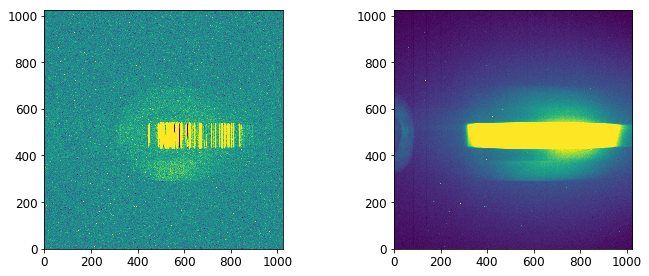

In [25]:
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize
from matplotlib import pyplot as plt

def znorm(image):
    return ImageNormalize(image, interval=ZScaleInterval())


def zimshow(ax, image, **kwargs):
    return ax.imshow(image, norm=znorm(image), origin='lower', **kwargs)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
data = fits.open(toppath / "comp_15-0001sp.fit")[0].data
zimshow(axs[0], data)
data = fits.open(toppath / "flat-0001sp.fit")[0].data
zimshow(axs[1], data)
plt.tight_layout()
plt.show()

As you can see, only small part of the whole CCD is useful. By some close look, I chose ``x=400~900`` and ``y=440~520`` to be sufficient. This will reduce the filesize and thus increase the calculation speed by factor of about 25 (= 1000pix / 500pix * 1000 pix / 80 pix).

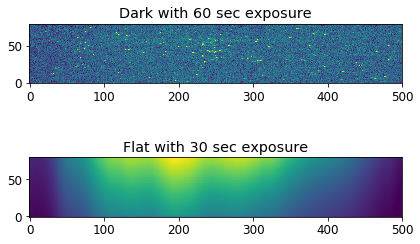

In [44]:
from pathlib import Path
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.nddata import CCDData

XMIN = 400
XMAX = 900
YMIN = 440
YMAX = 520
calibpath = toppath / "calibration"
Path.mkdir(calibpath, mode=0o777, exist_ok=True)

# Reload so that you can use this code independently regardless whether you've run the above code
# Also I used pandas than astropy.table.Table to be more "standard"
summarytab = pd.read_csv(toppath / "summary_20181023.csv")
grouped = summarytab.groupby(["OBJECT", "EXPTIME"])

for name, group in grouped:
    if name[0] in ["cali", "flat", "comp_10", "comp_15"]:
        savepath = calibpath / f"{name[0]}_{name[1]:.1f}.fits"  
        # ``20181023/calibration/object_exptime.fits``, exptime with 1 decimal pt
        ccds = []
        for fpath in group["file"]:
            ccd = fits.open(fpath)
            ccds.append(ccd[0].data[YMIN:YMAX, XMIN:XMAX])
        combined = np.median(ccds, axis=0)
        hdr = ccd[0].header  # an arbitrary header: the last of the combined ccds
        hdr["NCOMBINE"] = (len(ccds), "Number of images combined")
        combined_ccd = CCDData(data=combined, header=hdr, unit="adu")
        combined_ccd.write(savepath, overwrite=True)

# As an example, show Flat and Dark 60 sec
fig, axs = plt.subplots(2, 1)
data = fits.open(calibpath / "cali_60.0.fits")[0].data
zimshow(axs[0], data)
axs[0].set_title("Dark with 60 sec exposure")
data = fits.open(calibpath / "flat_30.0.fits")[0].data
zimshow(axs[1], data)
axs[1].set_title("Flat with 30 sec exposure")
plt.tight_layout()
plt.show()

After the combination, what we have to do is the preprocessing. Actually, since we took all the dark frames with identical exposure times for all the images, we don't need bias image (``cali_0.0.fits``) at all except for the test purpose. So I will ignore bias for now, and only do dark subtraction and flat fielding.

What I will do are
1. Dark subtraction to flat: Flat - Dark (``EXPTIME = 30``)
2. Preprocessing to comparison: (comp - Dark) / (Flat - Dark) (``EXPTIME = 10, 15``)
3. Preprocessing to all object images: 

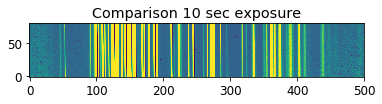

In [45]:
import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData

calibpath = toppath / "calibration"
allfits = calibpath.glob("*.fits")

flatpath = calibpath / "flat_30.0.fits"
flat_raw = fits.open(flatpath)
flat_exp = flat_raw[0].header["EXPTIME"]
dark4flatpath = calibpath / f"cali_{flat_exp:.1f}.fits"
dark4flat = fits.open(dark4flatpath)
flat_b_raw = data=flat_raw[0].data - dark4flat[0].data
flat_b = CCDData(data=flat_b_raw / np.mean(flat_b_raw),
                 header=flat_raw[0].header, unit='adu')
flat_b.header["HISTORY"] = f"Darksub (file={dark4flatpath})"
flat_b.write(calibpath / "master_flat.fits", overwrite=True)

for fpath in allfits:
    if fpath.name.startswith("comp"):
        comp_raw = fits.open(fpath)
        comp_exp = flat_raw[0].header["EXPTIME"]
        dark4comppath = calibpath / f"cali_{comp_exp:.1f}.fits"
        dark4comp = fits.open(dark4flatpath)
        comp_b = CCDData(data=comp_raw[0].data - dark4comp[0].data,
                         header=comp_raw[0].header, unit='adu')
        comp_b.header["HISTORY"] = f"Darksub (file={dark4flatpath})"
        
        flat4comppath = calibpath / "master_flat.fits"
        flat4comp = fits.open(flat4comppath)
        comp_bf = CCDData(data=comp_b.data / flat4comp[0].data,
                          header=comp_b.header, unit='adu')
        comp_bf.header["HISTORY"] = f"Flatcor (file={flat4comppath})"
        
        comp_bf.write(calibpath / f"master_{fpath.name}", overwrite=True)


# As an example, show comparison 10 sec
data = fits.open(calibpath / "master_comp_10_10.0.fits")[0].data
fig, ax = plt.subplots(1, 1)
zimshow(ax, data)
ax.set_title("Comparison 10 sec exposure")
plt.show()

The image looks funny since the stretch is not proper (because the flat does not fully include the wavelength range). Possible cure can be done by manually set ``vmin`` and ``vmax``:

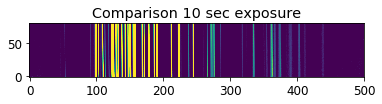

In [46]:
# As an example, show comparison 10 sec
data = fits.open(calibpath / "master_comp_10_10.0.fits")[0].data
fig, ax = plt.subplots(1, 1)
zimshow(ax, data, vmin=100, vmax=1000)
ax.set_title("Comparison 10 sec exposure")
plt.show()

Now Preprocess all object frames:

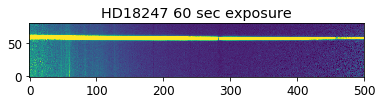

In [48]:
from pathlib import Path
import pandas as pd
import numpy as np
from astropy.nddata import CCDData

XMIN = 400
XMAX = 900
YMIN = 440
YMAX = 520
redpath = toppath / "reduced"
Path.mkdir(redpath, mode=0o777, exist_ok=True)

summarytab = pd.read_csv(toppath / "summary_20181023.csv")
grouped = summarytab.groupby(["OBJECT", "EXPTIME"])

for name, group in grouped:
    if name[0] not in ["cali", "flat", "comp_10", "comp_15"]:
        # ``20181023/reduced/object_exptime.fits``, exptime with 1 decimal pt
        for i, fpath in enumerate(group["file"]):
            savepath = redpath / f"{name[0]}_{name[1]:.1f}_{i+1}.fits"  
            ccd = fits.open(fpath)[0]
            exptime = ccd.header["EXPTIME"]
            darkpath = calibpath / f"cali_{exptime:.1f}.fits"
            flatpath = calibpath / f"master_flat.fits"
            reduced = CCDData(data=(ccd.data[YMIN:YMAX, XMIN:XMAX] - fits.getdata(darkpath)) / fits.getdata(flatpath),
                              header=ccd.header, unit='adu')
            reduced.header["HISTORY"] = f"Darksub (file={darkpath})"
            reduced.header["HISTORY"] = f"Flatcor (file={flatpath})"
            reduced.write(savepath, overwrite=True)
            
# As an example, show HD18247 60 sec
data = fits.open(redpath / "HD18247_60.0_5.fits")[0].data
fig, ax = plt.subplots(1, 1)
zimshow(ax, data)
ax.set_title("HD18247 60 sec exposure")
plt.show()

See the next lecture note for the detail, but here let me just show the wavelength identification process. I referred to [here](http://www.ing.iac.es/astronomy/instruments/af2_15aug13/arcNeonR0316R_a.jpg) and [here](http://www.ing.iac.es/astronomy/instruments/af2_15aug13/arcNeonR0316R_b.jpg). They are from [this website](http://www.ing.iac.es/astronomy/instruments/af2_15aug13/dispersion.html).

In [71]:
from pathlib import Path
import numpy as np

from numpy.polynomial.chebyshev import chebfit, chebval

from matplotlib import pyplot as plt
from matplotlib import gridspec, rcParams, rc
from matplotlib.widgets import Cursor

from astropy.table import Table, Column
from astropy.io import fits
from astropy.stats import sigma_clip, gaussian_fwhm_to_sigma
from astropy.modeling.models import Gaussian1D, Chebyshev2D
from astropy.modeling.fitting import LevMarLSQFitter

from skimage.feature import peak_local_max

def disable_mplkeymaps():
    rc('keymap', 
       fullscreen='',
       home='',
       back='',
       forward='',
       pan='',
       zoom='',
       save='',
       quit='',
       grid='',
       yscale='',
       xscale='',
       all_axes=''
       )
    
def set_dispaxis(data, dispaxis):
    if dispaxis not in [1, 2]:
        raise ValueError(f'DISPAXIS must be 1 or 2 (it is now {dispaxis})')

    if dispaxis == 2:
        data = data.T
    
    return data
    
    
toppath = Path('20181023')
calibpath = toppath / "calibration"
#%%
DISPAXIS = 1 # 1 = line = python_axis_1 // 2 = column = python_axis_0
FONTSIZE = 12 # Change it on your computer if you wish.
rcParams.update({'font.size': FONTSIZE})
COMPIMAGE = Path(calibpath / "master_comp_10_10.0.fits") # Change directory if needed!
OBJIMAGE  = Path('45P', 'pobj_mls170213_0025.fits')
LINE_FITTER = LevMarLSQFitter()

# Parameters for IDENTIFY
FITTING_MODEL_ID = 'Chebyshev'
ORDER_ID = 4 
NSUM_ID = 10
FWHM_ID = 4 # rough guess of FWHM of lines in IDENTIFY (pixels)

# Parameters for REIDENTIFY
FITTING_MODEL_REID = 'Chebyshev' # 2-D fitting function
ORDER_SPATIAL_REID = 6
ORDER_WAVELEN_REID = 6
STEP_REID = 10  # Reidentification step size in pixels (spatial direction)
NSUM_REID = 10
TOL_REID = 5 # tolerence to lose a line in pixels

# Parameters for APALL (sky fitting and aperture extract after sky subtraction)
## parameters for finding aperture
NSUM_AP = 10
FWHM_AP = 10
STEP_AP = 10  # Recentering step size in pixels (dispersion direction)
## parameters for sky fitting
FITTING_MODEL_APSKY = 'Chebyshev'
ORDER_APSKY = 3
SIGMA_APSKY = 3
ITERS_APSKY = 5
## parameters for aperture tracing
FITTING_MODEL_APTRACE = 'Chebyshev'
ORDER_APTRACE = 5
SIGMA_APTRACE = 3
ITERS_APTRACE = 5 
# The fitting is done by SIGMA_APTRACE-sigma ITERS_APTRACE-iters clipped on the
# residual of data. 

#%%
lamphdu = fits.open(COMPIMAGE)
lampimage = set_dispaxis(lamphdu[0].data, DISPAXIS)
#objhdu = fits.open(OBJIMAGE)
#objimage  = set_dispaxis(objhdu[0].data, DISPAXIS)
#EXPTIME = objhdu[0].header['EXPTIME']
#OBJNAME = objhdu[0].header['OBJECT']
#if lampimage.shape != objimage.shape:
#    raise ValueError('lamp and obj images should have same sizes!')

# Now python axis 0 (Y-direction) is the spatial axis 
# and 1 (X-direciton) is the wavelength (dispersion) axis.
N_SPATIAL, N_WAVELEN = np.shape(lampimage)
N_REID = N_SPATIAL//STEP_REID # No. of reidentification
N_AP = N_WAVELEN//STEP_AP # No. of aperture finding

# ``peak_local_max`` calculates the peak location using maximum filter:
#   med1d_max = scipy.ndimage.maximum_filter(med1d, size=10, mode='constant')
# I will use this to show peaks in a primitive manner.
MINSEP_PK = 5   # minimum separation of peaks
MINAMP_PK = 0.01 # fraction of minimum amplitude (wrt maximum) to regard as peak
NMAX_PK = 50
print("setting done!")

setting done!


In [ ]:
# =============================================================================
# Identify (1): plot for manual input
# =============================================================================
# mimics IRAF IDENTIFY
#   IDENTIIFY image.fits section='middle line' nsum=NSUM_ID
lowercut_ID = N_SPATIAL//2 - NSUM_ID//2 
uppercut_ID = N_SPATIAL//2 + NSUM_ID//2
identify_1 = np.median(lampimage[lowercut_ID:uppercut_ID, :], axis=0)
x_identify = np.arange(0, len(identify_1))

# For plot and visualization
max_intens = np.max(identify_1)

peak_pix = peak_local_max(identify_1, indices=True, num_peaks=NMAX_PK,
                          min_distance=MINSEP_PK,
                          threshold_abs=max_intens * MINAMP_PK)
# ``peak_pix`` corresponds to the x value, since x = pixels starting from 0.
# disable_mplkeymaps()
# fig = plt.figure()
# ax = fig.add_subplot(111)
# title_str = r'Peak ($A \geq {:.2f} A_\mathrm{{max}}$, $\Delta x \geq {:.0f}$)'
# # Plot original spectrum + found peak locations
# ax.plot(x_identify, identify_1, lw=1)

# for i in peak_pix:
#     ax.plot((i, i), 
#             (identify_1[i]+0.01*max_intens, identify_1[i]+0.05*max_intens),
#             color='r', ls='-', lw=1)
#     ax.annotate(i[0], (i, 0.9),
#                 xycoords = ('data', 'axes fraction'),
#                 fontsize='xx-small', rotation=70)
# ax.grid(ls=':')
# ax.set_xlabel('Pixel number')
# ax.set_ylabel('Pixel value sum')
# #ax.set_xlim(len(identify_1), 0) # to invert x-axis
# ax.set_title(title_str.format(MINAMP_PK, MINSEP_PK))
# plt.show()

What you have to do at this cell is "pattern matching":

![](figs/identify_tutorial.png)

Then you will be able to make ``ID_init`` as below:

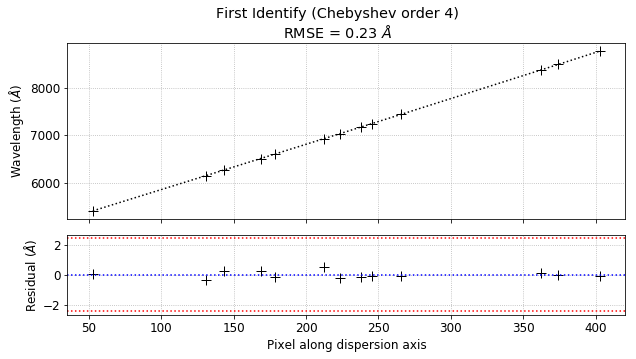

In [58]:
#%%
# You shouldn't have made any typo here!!!
# The number and range of initial points may depend on your goal accuracy.
ID_init = dict(pixel_init=[403, 374, 362, 265,
                           245, 238, 223, 213,
                           178, 169, 144, 131, 53],
               wavelength=[8780.6, 8495.4, 8377.6, 7438.9,
                           7245.2, 7173.9, 7032.4, 6929.5,
                           6599.0, 6507.0, 6266.5, 6143.1, 5400.6])
ID_init = Table(ID_init)

peak_gauss = []
fitter = LevMarLSQFitter()

for peak_pix in ID_init['pixel_init']:
    #TODO: Drop the use of astropy fitting since bounds shouldn't be used for
    #   Levenberg-Marquadt algorithm but strangely astropy accepts it... 
    #   Can't believe it.
    g_init = Gaussian1D(amplitude = identify_1[peak_pix], 
                        mean = peak_pix, 
                        stddev = FWHM_ID * gaussian_fwhm_to_sigma,
                        bounds={'amplitude': (0, 2*identify_1[peak_pix]),
                                'mean':(peak_pix-FWHM_ID, peak_pix+FWHM_ID),
                                'stddev':(0, FWHM_ID)})
    fitted = LINE_FITTER(g_init, x_identify, identify_1)
    peak_gauss.append(fitted.mean.value)
    
ID_init["pixel_gauss"] = peak_gauss
ID_init["pixel_shift"] = peak_gauss - ID_init['pixel_init']

ID_init.sort('wavelength')

#%%
if FITTING_MODEL_ID.lower() == 'chebyshev':
    coeff_ID, fitfull = chebfit(ID_init['pixel_gauss'], 
                                ID_init['wavelength'], 
                                deg=ORDER_ID,
                                full=True)
    fitRMS = np.sqrt(fitfull[0][0]/len(ID_init))
    rough_error = ( np.ptp(ID_init['wavelength']) 
                   / np.ptp(ID_init['pixel_gauss']) ) / 2
    # rough_error = (wave_max - wave_min) / (spatial_max - spatial_min)
    residual = ( ID_init['wavelength'] 
                - chebval(ID_init['pixel_gauss'], coeff_ID))
    res_range = np.max(np.abs(residual))
else:
    raise ValueError('Function {:s} is not implemented.'.format(FITTING_MODEL_REID))

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(3, 1)
ax1 = plt.subplot(gs[0:2])
ax2 = plt.subplot(gs[2])
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.plot(ID_init['pixel_gauss'], ID_init['wavelength'],
         ls=':', color='k', ms=10, marker='+')
ax2.plot(ID_init['pixel_gauss'], residual, 
         ls='', color='k', ms=10, marker='+')
ax2.axhline(y=0, color='b', ls=':')
# rough error ~ +- wavelength resolution/2
ax2.axhline(y=-rough_error/2, color='r', ls=':')
ax2.axhline(y=+rough_error/2, color='r', ls=':')
ax2.set_ylim(min(-rough_error/2 * 1.1, -1.1*res_range), 
             max(+rough_error/2 * 1.1, +1.1*res_range))
ax1.set_ylabel(r'Wavelength ($\AA$)')
ax2.set_ylabel(r'Residual ($\AA$)')
ax2.set_xlabel('Pixel along dispersion axis')
ax1.grid(ls=':')
ax2.grid(ls=':')
plt.suptitle(('First Identify (Chebyshev order {:d})\n'.format(ORDER_ID) 
              + r'RMSE = {:.2f} $\AA$'.format(fitRMS)))
plt.show()

In [59]:
# =============================================================================
# reidentify
# =============================================================================
# For REIDENTIFY, I used astropy.modeling.models.Chebyshev2D

line_REID = np.zeros((len(ID_init), N_REID-1))
spatialcoord = np.arange(0, (N_REID - 1) * STEP_REID, STEP_REID) + STEP_REID / 2

print('Reidentify each section by Chebyshev (order {:d})'.format(ORDER_ID))
print('section      |  found  |  RMS')

for i in range(0, N_REID-1):
    lower_cut, upper_cut = i*STEP_REID, (i+1)*STEP_REID
    reidentify_i = np.sum(lampimage[lower_cut:upper_cut, :], 
                          axis=0)
    peak_gauss_REID = []
    
    for peak_pix_init in ID_init['pixel_gauss']:
        # TODO: Will a simple astropy fitting work well for general cases?
        #TODO: put something like "lost_factor" to multiply to FWHM_ID in the bounds.
        search_min = int(np.around(peak_pix_init - TOL_REID))
        search_max = int(np.around(peak_pix_init + TOL_REID))
        cropped = reidentify_i[search_min:search_max]
        x_cropped = np.arange(len(cropped)) + search_min
        
        #TODO: put something like "lost_factor" to multiply to FWHM_ID in the bounds.
        A_init = np.max(cropped)
        mean_init = peak_pix_init
        stddev_init = FWHM_ID * gaussian_fwhm_to_sigma
        g_init = Gaussian1D(amplitude=A_init, mean=mean_init, stddev=stddev_init,
                            bounds={'amplitude':(0, 2*np.max(cropped)) ,
                                    'stddev':(0, TOL_REID)})
        g_fit = fitter(g_init, x_cropped, cropped)    
        fit_center = g_fit.mean.value
        if abs(fit_center - peak_pix_init) > TOL_REID:
            peak_gauss_REID.append(np.nan)
            continue
        peak_gauss_REID.append(fit_center)

    peak_gauss_REID = np.array(peak_gauss_REID)
    nonan_REID = np.isfinite(peak_gauss_REID)
    line_REID[:, i] = peak_gauss_REID
    peak_gauss_REID_nonan = peak_gauss_REID[nonan_REID]
    n_tot = len(peak_gauss_REID)
    n_found = np.count_nonzero(nonan_REID)
    
    if FITTING_MODEL_ID.lower() == 'chebyshev':
        coeff_REID1D, fitfull = chebfit(peak_gauss_REID_nonan,
                                        ID_init['wavelength'][nonan_REID], 
                                        deg=ORDER_WAVELEN_REID,
                                        full=True)
        fitRMS = np.sqrt(fitfull[0][0]/n_found)
    
    else:
        raise ValueError('Function {:s} is not implemented.'.format(FITTING_MODEL_REID))

    print('[{:04d}:{:04d}]\t{:d}/{:d}\t{:.3f}'.format(lower_cut, upper_cut,
                                                      n_found, n_tot, fitRMS))

points = np.vstack((line_REID.flatten(),
                    np.tile(spatialcoord, len(line_REID))))
points = points.T # list of ()
nanmask = ( np.isnan(points[:,0]) | np.isnan(points[:,1]) )
points = points[~nanmask]
values = np.repeat(ID_init['wavelength'], N_REID - 1)
values = np.array(values.tolist())
values = values[~nanmask]
errors = np.ones_like(values)

if FITTING_MODEL_REID.lower() == 'chebyshev':
    coeff_init = Chebyshev2D(x_degree=ORDER_WAVELEN_REID, y_degree=ORDER_SPATIAL_REID)
    fit2D_REID = fitter(coeff_init, points[:, 0], points[:, 1], values)
    ww, ss = np.mgrid[:N_WAVELEN, :N_SPATIAL]
else:
    raise ValueError('Function {:s} is not implemented.'.format(FITTING_MODEL_REID))

Reidentify each section by Chebyshev (order 4)
section      |  found  |  RMS
[0000:0010]	13/13	0.342
[0010:0020]	13/13	0.429
[0020:0030]	13/13	0.344
[0030:0040]	13/13	0.239
[0040:0050]	13/13	0.136
[0050:0060]	13/13	0.077
[0060:0070]	13/13	0.149


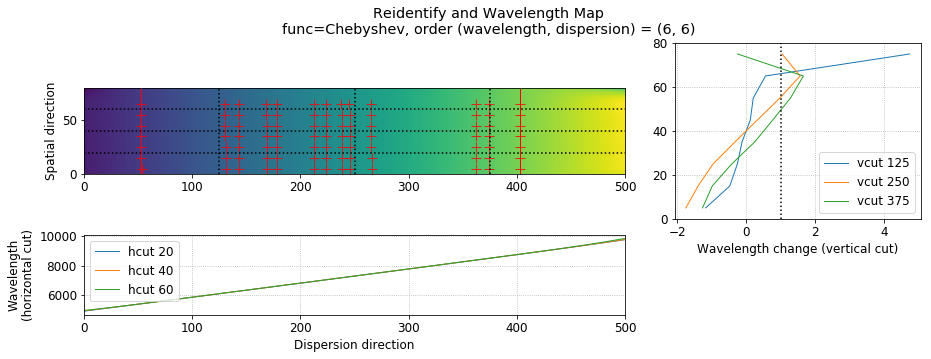

In [66]:

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[:2, :2])
ax2 = plt.subplot(gs[2, :2])
ax3 = plt.subplot(gs[:2, 2])
#plt.setp(ax2.get_xticklabels(), visible=False)
#plt.setp(ax3.get_yticklabels(), visible=False)

title_str = ('Reidentify and Wavelength Map\n'
             + 'func=Chebyshev, order (wavelength, dispersion) = ({:d}, {:d})')
plt.suptitle(title_str.format(ORDER_WAVELEN_REID, ORDER_SPATIAL_REID))

interp_min = line_REID[~np.isnan(line_REID)].min()
interp_max = line_REID[~np.isnan(line_REID)].max()

ax1.imshow(fit2D_REID(ww, ss).T, origin='lower')
ax1.axvline(interp_max, color='r', lw=1)
ax1.axvline(interp_min, color='r', lw=1)
#ax1.text((interp_max+interp_min)/2, -10, "Fitting Region",
#         horizontalalignment="center",
#         bbox={'facecolor':'red', 'alpha':0.8, 'pad':10})
ax1.plot(points[:, 0], points[:, 1], ls='', marker='+', color='r',
         alpha=0.8, ms=10)


for i in (1, 2, 3):
    vcut = N_WAVELEN * i/4
    hcut = N_SPATIAL * i/4
    vcutax  = np.arange(0, N_SPATIAL, STEP_REID) + STEP_REID/2
    hcutax  = np.arange(0, N_WAVELEN, 1)
    vcutrep = np.repeat(vcut, len(vcutax))
    hcutrep = np.repeat(hcut, len(hcutax))
    
    ax1.axvline(x=vcut, ls=':', color='k')   
    ax1.axhline(y=hcut, ls=':', color='k')
    
    ax2.plot(hcutax, fit2D_REID(hcutax, hcutrep), lw=1, 
             label="hcut {:d}".format(int(hcut)))

    vcut_profile = fit2D_REID(vcutrep, vcutax)
    vcut_normalize = vcut_profile - np.median(vcut_profile)
    ax3.plot(vcut_normalize, vcutax, lw=1,
             label="vcut {:d}".format(int(vcut)))

ax1.set_ylabel('Spatial direction')
ax2.grid(ls=':')
ax2.legend()
ax2.set_xlabel('Dispersion direction')
ax2.set_ylabel('Wavelength\n(horizontal cut)')

ax3.axvline(1, ls=':', color='k')
ax3.grid(ls=':', which='both')
ax3.set_xlabel('Wavelength change (vertical cut)')
ax3.legend()

ax1.set_ylim(0, N_SPATIAL)
ax1.set_xlim(0, N_WAVELEN)
ax2.set_xlim(0, N_WAVELEN)
ax3.set_ylim(0, N_SPATIAL)
plt.show()

The extrapolation region (x larger than about 400) is very uncertain, and you should not rely much on the reidentification at that region. The fitted coefficient object will be used throughout the reduction:

In [67]:
print(fit2D_REID)

Model: Chebyshev2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
X-Degree: 6
Y-Degree: 6
Parameters:
           c0_0              c1_0        ...           c6_6         
    ----------------- ------------------ ... -----------------------
    4847.182790336618 11.382967751278361 ... -3.0153108510495906e-24


Now we need aperture trace:

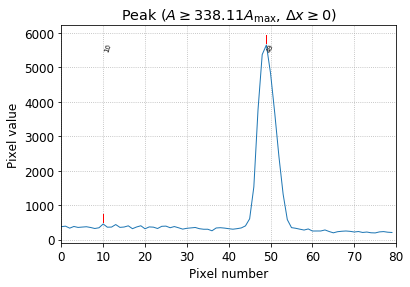

In [68]:
# =============================================================================
# apall (1): Plot a cut
# =============================================================================
redpath = toppath / "reduced"

OBJIMAGE = Path(redpath / "uranus_30.0_9.fits")
objhdu = fits.open(OBJIMAGE)
objimage  = set_dispaxis(objhdu[0].data, DISPAXIS)
EXPTIME = objhdu[0].header['EXPTIME']
OBJNAME = objhdu[0].header['OBJECT']

lower_cut = N_WAVELEN//2 - NSUM_AP//2 
upper_cut = N_WAVELEN//2 + NSUM_AP//2
apall_1 = np.sum(objimage[:, lower_cut:upper_cut], axis=1)
max_intens = np.max(apall_1)

peak_pix = peak_local_max(apall_1, indices=True, num_peaks=10,
                          min_distance=int(N_SPATIAL/10),
                          threshold_abs=np.median(apall_1))

x_apall = np.arange(0, len(apall_1))

fig = plt.figure()
ax = fig.add_subplot(111)
title_str = r'Peak ($A \geq {:.2f} A_\mathrm{{max}}$, $\Delta x \geq {:.0f}$)'

ax.plot(x_apall, apall_1, lw=1)

for i in peak_pix:
    ax.plot((i, i), 
            (apall_1[i]+0.01*max_intens, apall_1[i]+0.05*max_intens),
            color='r', ls='-', lw=1)
    ax.annotate(i[0], (i, 0.9),
                xycoords = ('data', 'axes fraction'),
                fontsize='xx-small', rotation=70)
ax.grid(ls=':')
ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value')
ax.set_xlim(0, len(apall_1))
ax.set_title(title_str.format(np.median(apall_1), int(N_SPATIAL/100)))
plt.show()

Using 49 as initial guess, use 30~40 and 60~70 as sky (or rather, peak -19~-9, peak +11~21)

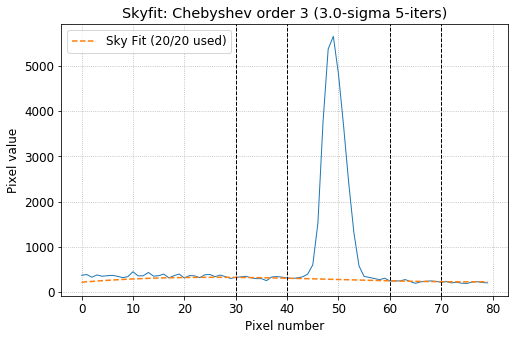

In [69]:
# =============================================================================
# apall(2): manually select sky, see how the fit works
# =============================================================================
ap_init = 49

ap_sky = np.array([30, 40, 60, 70])
# Regions to use as sky background. xl1 - 1, xu1, xl2 - 1, xu2. (0-indexing)
#   Sky region should also move with aperture center!
#   from ``ap_center - 50`` to ``ap_center - 40``, for example, should be used.
# TODO: accept any even-number-sized ap_sky.

# Interactive check
x_sky = np.hstack( (np.arange(ap_sky[0], ap_sky[1]), 
                    np.arange(ap_sky[2], ap_sky[3])))
sky_val = np.hstack( (apall_1[ap_sky[0]:ap_sky[1]], 
                      apall_1[ap_sky[2]:ap_sky[3]]))

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
title_str = r'Skyfit: {:s} order {:d} ({:.1f}-sigma {:d}-iters)'
ax.plot(x_apall, apall_1, lw=1)

if FITTING_MODEL_APSKY.lower() == 'chebyshev':
    # TODO: maybe the clip is "3-sigma clip to residual and re-fit many times"?
    clip_mask = sigma_clip(sky_val, sigma=SIGMA_APSKY, iters=ITERS_APSKY).mask
    coeff_apsky, fitfull = chebfit(x_sky[~clip_mask], 
                                   sky_val[~clip_mask],
                                   deg=ORDER_APSKY,
                                   full=True)
    fitRMS = np.sqrt(fitfull[0][0]/n_found)
    n_sky = len(x_sky)
    n_rej = np.count_nonzero(clip_mask)
    sky_fit = chebval(x_apall, coeff_apsky) 
    ax.plot(x_apall, sky_fit, ls='--',
            label='Sky Fit ({:d}/{:d} used)'.format(n_sky - n_rej, n_sky))
    ax.plot(x_sky[clip_mask], sky_val[clip_mask], marker='x', ls='', ms=10)
    [ax.axvline(i, lw=1, color='k', ls='--') for i in ap_sky]
    ax.legend()
    ax.set_title(title_str.format(FITTING_MODEL_APSKY, ORDER_APSKY,
                                  SIGMA_APSKY, ITERS_APSKY))
    ax.set_xlabel('Pixel number')
    ax.set_ylabel('Pixel value sum')
    
else:
    raise ValueError('Function {:s} is not implemented.'.format(FITTING_MODEL_REID))
ax.grid(ls=':')
ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value')
plt.show()

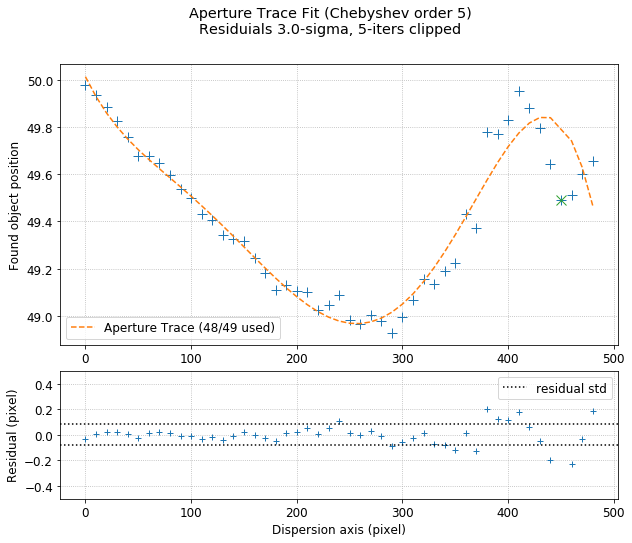

In [72]:
# =============================================================================
# apall (3): aperture trace
# =============================================================================
# within +- 100 pixels around the aperture, the wavelength does not change much
# as can be seen from reidentify figure 
# (in NHAO case, ~ 0.01% ~ 0.1 Angstrom order).
# So it's safe to assume the wavelength is constant over around such region,
# (spatial direction) and thus I will do sky fitting from this column,
# without considering the wavelength change along a column.
# Then aperture extraction will map the pixel to wavelength using aperture
# trace solution.

aptrace = []
aptrace_fwhm = []
#coeff_apsky = []
#aptrace_apsum = []
#aptrace_wavelen = []

# TODO: This is quite slow as for loop used: improvement needed.
# I guess the problem is sigma-clipping rather than fitting process..
for i in range(N_AP - 1):
    lower_cut, upper_cut = i*STEP_AP, (i+1)*STEP_AP
    
    apall_i = np.sum(objimage[:, lower_cut:upper_cut], axis=1)
    sky_val = np.hstack( (apall_i[ap_sky[0]:ap_sky[1]], 
                          apall_i[ap_sky[2]:ap_sky[3]]))
    
    # Subtract fitted sky
    if FITTING_MODEL_APSKY.lower() == 'chebyshev':
        # TODO: maybe we can put smoothing function as IRAF APALL's b_naverage 
        clip_mask = sigma_clip(sky_val, sigma=SIGMA_APSKY, iters=ITERS_APSKY).mask
        coeff, fitfull = chebfit(x_sky[~clip_mask], 
                                 sky_val[~clip_mask],
                                 deg=ORDER_APSKY,
                                 full=True)
        apall_i -= chebval(x_apall, coeff)
#        fitRMS = np.sqrt(fitfull[0][0]/n_found)
#        n_sky = len(x_sky)
#        n_rej = np.count_nonzero(clip_mask)
    
    else:
        raise ValueError('Function {:s} is not implemented.'.format(FITTING_MODEL_APSKY))

    #TODO: put something like "lost_factor" to multiply to FWHM_ID in the bounds.
    search_min = int(np.around(ap_init - 3*FWHM_AP))
    search_max = int(np.around(ap_init + 3*FWHM_AP))
    cropped = apall_i[search_min:search_max]
    x_cropped = np.arange(len(cropped))
    peak_pix = peak_local_max(cropped, 
                              min_distance=FWHM_AP,
                              indices=True,
                              num_peaks=1)
    if len(peak_pix) == 0:
        aptrace.append(np.nan)
        continue
    peak_pix = peak_pix[0][0]
    
    #TODO: put something like "lost_factor" to multiply to FWHM_ID in the bounds.
    g_init = Gaussian1D(amplitude=cropped[peak_pix], 
                       mean=peak_pix, 
                       stddev=FWHM_AP * gaussian_fwhm_to_sigma,
                       bounds={'amplitude':(0, 2*cropped[peak_pix]) ,
                               'mean':(peak_pix-3*FWHM_AP, peak_pix+3*FWHM_AP),
                               'stddev':(0, FWHM_AP)})
    fitted = fitter(g_init, x_cropped, cropped)
    center_pix = fitted.mean.value + search_min
    std_pix = fitted.stddev.value
    aptrace_fwhm.append(fitted.fwhm)
    aptrace.append(center_pix)
#    coeff_apsky.append(coeff)
#    aptrace_apsum.append(apsum)
#    apsum_lower = int(np.around(center_pix - apsum_sigma_lower * std_pix))
#    apsum_upper = int(np.around(center_pix + apsum_sigma_upper * std_pix))
#    apsum = np.sum(apall_i[apsum_lower:apsum_upper])

aptrace = np.array(aptrace)
aptrace_fwhm = np.array(aptrace_fwhm)
#coeff_apsky = np.array(coeff_apsky)
#aptrace_apsum = np.array(aptrace_apsum)

#%%
# =============================================================================
# apall(4): aperture trace fit
# =============================================================================
x_aptrace = np.arange(N_AP-1) * STEP_AP

coeff_aptrace = chebfit(x_aptrace, aptrace, deg=ORDER_APTRACE)
resid_mask = sigma_clip(aptrace - chebval(x_aptrace, coeff_aptrace), 
                        sigma=SIGMA_APTRACE, iters=ITERS_APTRACE).mask

x_aptrace_fin = x_aptrace[~resid_mask]
aptrace_fin = aptrace[~resid_mask]
coeff_aptrace_fin = chebfit(x_aptrace_fin, aptrace_fin, deg=ORDER_APTRACE)
fit_aptrace_fin   = chebval(x_aptrace_fin, coeff_aptrace_fin)
resid_aptrace_fin = aptrace_fin - fit_aptrace_fin
del_aptrace = ~np.in1d(x_aptrace, x_aptrace_fin) # deleted points

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 1)
ax1 = plt.subplot(gs[0:2], sharex=ax2)
ax2 = plt.subplot(gs[2])

title_str = ('Aperture Trace Fit ({:s} order {:d})\n'
            + 'Residuials {:.1f}-sigma, {:d}-iters clipped')
plt.suptitle(title_str.format(FITTING_MODEL_APTRACE, ORDER_APTRACE,
                              SIGMA_APTRACE, ITERS_APTRACE))
ax1.plot(x_aptrace, aptrace, ls='', marker='+', ms=10)
ax1.plot(x_aptrace_fin, fit_aptrace_fin, ls='--',
         label="Aperture Trace ({:d}/{:d} used)".format(len(aptrace_fin), N_AP-1))
ax1.plot(x_aptrace[del_aptrace], aptrace[del_aptrace], ls='', marker='x', ms=10)
ax1.legend()
ax2.plot(x_aptrace_fin, resid_aptrace_fin, ls='', marker='+')
#ax2.plot(x_aptrace, aptrace - chebval(x_aptrace, coeff_aptrace_fin), 
#         ls='', marker='+')
ax2.axhline(+np.std(resid_aptrace_fin, ddof=1), ls=':', color='k')
ax2.axhline(-np.std(resid_aptrace_fin, ddof=1), ls=':', color='k', 
            label='residual std')

ax1.set_ylabel('Found object position')
ax2.set_ylabel('Residual (pixel)')
ax2.set_xlabel('Dispersion axis (pixel)')
ax1.grid(ls=':')
ax2.grid(ls=':')
ax2.set_ylim(-.5, .5)
ax2.legend()
plt.show()
#plt.savefig('aptrace.png', bbox_inches='tight')

Note that after 1 rejection, the residual is much less than 1 pixel, and I think it is sufficient to our purpose.

Now we do aperture summation:

In [76]:
# =============================================================================
# apall(5): aperture sum
# =============================================================================
apsum_sigma_lower = 2.104 # See below
apsum_sigma_upper = 2.130 
# lower and upper limits of aperture to set from the center in gauss-sigma unit.
ap_fwhm = np.median(aptrace_fwhm[~resid_mask])
ap_sigma = ap_fwhm * gaussian_fwhm_to_sigma

x_ap = np.arange(N_WAVELEN)
y_ap = chebval(x_ap, coeff_aptrace_fin)
ap_wavelen = fit2D_REID(x_ap, y_ap)
ap_summed  = []
ap_sky_offset = ap_sky - ap_init

for i in range(N_WAVELEN):
    cut_i = objimage[:, i]
    ap_sky_i = int(y_ap[i]) + ap_sky_offset
   
    lower = y_ap[i] - apsum_sigma_lower * ap_sigma
    upper = y_ap[i] + apsum_sigma_upper * ap_sigma + 1
    # + 1 required since python regards, e.g., list[1:3] = list[1], list[2] (NOT list[3] included).
    
    x_obj_lower = int(np.around(y_ap[i] - apsum_sigma_lower * ap_sigma))
    x_obj_upper = int(np.around(y_ap[i] + apsum_sigma_upper * ap_sigma)) 
    x_obj = np.arange(x_obj_lower, x_obj_upper)
    obj_i = cut_i[x_obj_lower:x_obj_upper]
   
    l_pix_w = x_obj_lower - lower - 0.5
    u_pix_w = upper - x_obj_upper - 0.5
   
    x_sky = np.hstack( (np.arange(ap_sky_i[0], ap_sky_i[1]),
                        np.arange(ap_sky_i[2], ap_sky_i[3])))
    sky_val = np.hstack( (cut_i[ap_sky_i[0]:ap_sky_i[1]],
                          cut_i[ap_sky_i[2]:ap_sky_i[3]]))
    clip_mask = sigma_clip(sky_val, sigma=SIGMA_APSKY, iters=ITERS_APSKY).mask
   
    coeff = chebfit(x_sky[~clip_mask],
                    sky_val[~clip_mask],
                    deg=ORDER_APSKY)

    obj_i -= chebval(x_obj, coeff)

    l_pix_val = obj_i[0] * l_pix_w   # negative value (hopefully)
    u_pix_val = obj_i[-1] * u_pix_w  # negative value (hopefully)

    ap_summed.append(np.sum(obj_i)+l_pix_val+u_pix_val)
#    print(lower, upper, ap_summed[i])

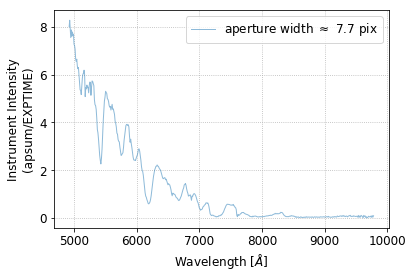

In [79]:
ap_summed = np.array(ap_summed) / EXPTIME
label_str = r'aperture width $\approx$ {:.1f} pix'

fig, ax = plt.subplots(1, 1)
ax.plot(ap_wavelen, ap_summed, lw = 1,
         alpha=0.5,
         label=label_str.format(apsum_sigma_lower * ap_sigma
                                + apsum_sigma_upper * ap_sigma))
ax.set_ylabel('Instrument Intensity\n(apsum/EXPTIME)')
ax.set_xlabel(r"Wavelength [$\AA$]")
ax.grid(ls=':')

ax.legend()
plt.show()

As we have no gain and read noise value for the CCD, Poisson noise cannot be calculated. In reality, you must consider ($O''$ = object image (not preprocessed), $D'$/$F'$ = raw dark/flat (not preprocessed), $R$ = read noise, $g$ = gain in electron/ADU)
1. Preprocess all: $D = D'-B$ and $F = F' - D' = F' - B - D$. For object, $O' = O'' - D' = O'' - D - B$ and $ O = O'/F $. 
1. Poisson and read noise from F: $\Delta F = \sqrt{ \left (\sqrt{(F + D)/g} \right)^2 + (R/g)^2} ~\mathrm{[ADU]}$ (note that dark has Poissonian noise)
1. Poisson and read noise from O': $\Delta O' = \sqrt{ \left (\sqrt{(O' + D)/g} \right)^2 + (R/g)^2} ~\mathrm{[ADU]}$. 
1. The error propagated from flat correction is $\Delta O = O \sqrt{\left ( \frac{\Delta O'}{O'} \right )^2 + \left ( \frac{\Delta F}{F} \right )^2} $ for each pixel of $O$. Note that $O$ is dimensionless since $O = O'/F'$.
1. The error from the sky estimation at each pixel to be aperture summed should be propagated, although you may use simple Gaussian assumption.

Normally the count for flat is ~20 k ADU, we can ignore the read noise and thus $\Delta F / F \sim (\sqrt{F/g}) / F \lesssim 0.5 \%$. The term $\Delta O'/O'$ depends on the signal to noise ratio, but usually much larger than $\Delta F / F$ term since we can hardly get counts of 20 k ADU for our faint targets. 

* **EXAMPLE**: Say we have $B=1000$, object $O'' = 3000$, $O' = 1990 $ (i.e., dark for object is 10), flat $F' = 21000$, $F = 19995$ (i.e., dark for flat is 5), and given that $g = 2$ and $R = 10$ (electrons; $R/g = 5$). Then for flat: $\Delta F = \sqrt{20000/2 + 5^2} \approx 100 $, or $\Delta F / F \approx 0.005007$, for object: $\Delta O' = \sqrt{2000/2 + 5^2} \approx 30 $ or $\Delta O' / O' \approx 0.016088$. Thus, $\Delta O \approx 0.0168 O $, i.e., about 1.7% uncertainty. If we ignore $\Delta F/F$ term, $\Delta O \approx 0.0161 O $. This discrepancy will increase as the object gets brighter, since the uncertainty from object's flux is getting smaller and gets comparable to the flat. This kind of uncertainty should be different for each pixel.

* **EXAMPLE**: If we estimated the sky using 100 sky pixels and we want to sum 10 pixels in the aperture, the uncertainties from the above calculation should be used. The estimated sky value will be more certain by factor of $\sqrt{N_s}$ by the central limit theorem ($N_s$: number of pixels used for the sky estimation; this is not exact since we are using polynomial fitting to the sky, not getting the average of it). But the number of pixels used to sum the aperture increases, so the final uncertainty will be $\Delta O_\mathrm{rigorous} = \sqrt{ (\Delta O)^2 + n_{ap} s_s / N_s } $ where $s_s$ is the standard deviation of the sky (this makes sense only if we are using mean sky value). The derivation was given in the lecture notes in AO1. 

* **EXAMPLE**: We estimated the sky using the pixels which have identical x values. But as we've seen in REID, this assumption breaks down in reality (same x do not necessarily correspont to same wavelength). If your data is of great scientific importance and you need very accurate results, this effect must be taken into account and very precise error estimation must be done.

Now we can reduce all other object frames too, and combine each of them. 

In [ ]:
specpath = toppath / "spectra"
Path.mkdir(specpath, mode=0o777, exist_ok=True)
redfits = redpath.glob("*.fits")

for fpath in redfits:
    